![](pics/docking.gif)

# Sliding Mode Control (SMC)

Kevin Walchko

20 June 2022

---

## References

- Walchko, K., “Robust Attitude Control with Disturbance Compensation,” Ph.D. Dissertation, University of Florida, Gainesville, FL, 2003.
- wikipedia: [Phase Portait](https://en.wikipedia.org/wiki/Phase_portrait)
- wikipedia: [Sliding Mode Control](https://en.wikipedia.org/wiki/Sliding_mode_control)
- walchko: [Quaternions](../quaternions/quaternions.ipynb)

# Sliding Mode Control

$$
\newcommand{\sgn}[1]{sgn \left( #1 \right)}
\newcommand{\sat}[1]{sat \left( #1 \right)}
$$

The sliding surface (s) is defined as:

$$
s = \left( \frac {d}{dt} + \lambda \right) \mathbf{e} \\
s = \mathbf{\dot e} + \lambda \mathbf{e} \\
$$

The sliding surface is a composite of the error and error rate seen by the system. The control command is given by:

$$
u = -K \sgn{s}
$$

where $K$ is a positive definate gain and the $\sgn{s}$ switches between signs in different quadrants of the phase portrait to drive the system to zero (origin).

> **Phase Portrait:** is a geometric representation of the trajectories of a dynamical system in the phase plane. Each set of initial conditions is represented by a different curve, or point. Phase portraits are an invaluable tool in studying dynamical systems. They consist of a plot of typical trajectories in the state space. This reveals information such as whether an attractor, a repellor or limit cycle is present for the chosen parameter value. 
> ![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/Van_der_pols_equation_phase_portrait.svg/197px-Van_der_pols_equation_phase_portrait.svg.png)

Now substituting the definitions for attitude error and rate error into the above equations, we get:

$$
s = \omega_e + \lambda q_{e:xyz} \\
\mathbf{e} = q_{e:xyz} \\
\mathbf{\dot e} = \omega_e
$$

Now taking the derivative of our sliding surface:

$$
\frac {d}{dt} s = \dot s = \dot \omega_e + \lambda \dot q_{e:xyz}
$$

## Saturation

The sign function used in the sliding mode controller leads to an excessive amount of
chattering in the control effort. A common modification to the sliding mode controller is to change the sign function to a saturation function with the following properties.

$$
\sat{a} = \left\{ \begin{array} . -1 < a < 1 & a \\ else & \sgn{a} \end{array} \right.
$$

Thus our control equation becomes:

$$
u = -K \sat{\frac {a}{\phi}}
$$

where $\phi$ is a scalar value used to adjust when saturation will occur.

## Lyapunov Stability

Let's define a posative definate Lyapunov function:

$$
V = \frac {1}{2} s^T J s
$$

Now, take its derivative and substitute in the equations of motion.

$$
\begin{align}
\dot V &= s^T J \dot s \\
&= s^T J (\dot \omega + \lambda  \dot q) \\
&= s^T(J \dot \omega + \lambda J  \dot q) \\
&= s^T [-\omega \cdot J \omega + g + \lambda J ( \frac {1}{2} (q^x + q_4 \bf 1) \omega )]
\end{align}
$$

Next solve for the control effort ($\hat u$):

$$
J \dot \omega + \dot J \omega = - \omega \cdot J \omega + g \\
\dot J \omega \approx 0
$$

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp as rk45
from squaternion import Quaternion
from helper import plotStates, plotControl

In [4]:
# desired quaternion
qd = Quaternion.from_euler(40,30,-40,degrees=True)

qe = qd.conjugate * Quaternion()
print(f"Error quaternion: {qe:.4f}")
print(f"  Rotation axis: {qe.axis}")
print(f"  Rotation angle: {qe.angle*180/np.pi:.4f} deg")

Error quaternion: Quaternion(w=0.8227, x=-0.3936, y=-0.1156, z=0.3936)
  Rotation axis: (-0.6923482794452575, -0.2032430070097958, 0.6923482794452575)
  Rotation angle: 69.2965 deg


In [90]:
class SatelliteWheels:
    """
    This is a slightly more realistic satellite model. In addition to 
    external torques, it also accounts for momentum within the satellite
    generated by the wheels.
    """
    J = np.diag([10,10,10])
    Tlim = 0.9 # Nm
    Hlim = 1.5 # Nms
    dz = 0.05  # Nm
    
    def dynamics(self, t, state, u):
        # state = [q(r,x,y,z), w, h_w]
        # u = torques(3)

        J = self.J
        q = Quaternion(*state[:4])
        w = state[4:7]
        h = state[7:10]
        qw = Quaternion(0, *w)

        ret = np.zeros(10)
        ret[:4] = 0.5*q*qw
        ret[4:7] = np.linalg.inv(J) @ (u - np.cross(w, J @ w) - np.cross(w, h))
        ret[7:10] = -u
            
        return ret
    
    def torqueLimit(self, u, limit=None, deadzone=None):
        # dead zone around 0
        # max torque limit
        if limit is None: limit = self.Tlim
        if deadzone is None: deadzone = self.dz
        
        for i in range(3):
            if -deadzone < u[i] < deadzone:
                u[i] = 0.0
            elif u[i] > limit:
                u[i] = limit
            elif u[i] < -limit:
                u[i] = -limit
        return u
    
    def momentumLimit(self, y, limit=None):
        # max momentum limit
        if limit is None: limit = self.Hlim
        
        for i in range(7,10):
            if y[i] > limit:
                y[i] = limit
            elif y[i] < -limit:
                y[i] = -limit
        return y
    
def saturate(x):
    """Use saturation instead of sign to reduce chattering"""
    ret = np.zeros(3)
    for i in range(3):
        if -1 < x[i] < 1:
            ret[i] = x[i]
        else:
            ret[i] = x[i]
    return ret

In [105]:
ti = []
yi = []
ui = []
err = []
errdot = []

sat = SatelliteWheels()
Js = sat.J 

step = 0.01
t = 0

# [q, w, h_w]
y = np.zeros(10)
y[:4] = Quaternion() # set starting quaternion

for i in range(2000):
    u = np.zeros(3)
    q = Quaternion(*y[:4])
    qe = qd.conjugate * q
    axis = np.array(qe.vector)
    
    we = y[4:7]
    L = 2.5
    K = 7.5
    s = we + L*axis
    u = - K * saturate(s)
    # u = -u
    # u = sat.torqueLimit(u, limit=0.09, deadzone=0.0)
    # y = sat.momentumLimit(y)
    
    y = rk45(sat.dynamics, [t, t+step], y, args=(u,))
    
    if y.success == False:
        print("Oops")
        
    y = y.y[:,-1]
    yi.append(y)
    t += step
    ti.append(t)
    ui.append(u)
    err.append(qe)
    errdot.append(y[4:7])
    
yi = np.array(yi)
ti = np.array(ti)
ui = np.array(ui)
err = np.array(err)
errdot = np.array(errdot)

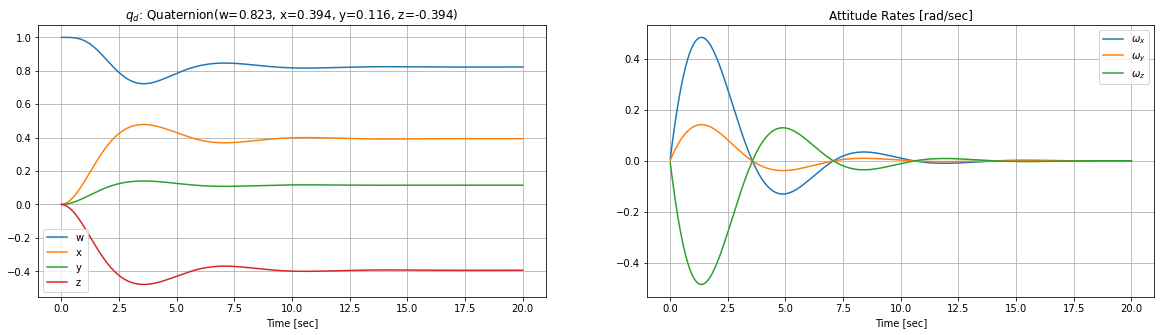

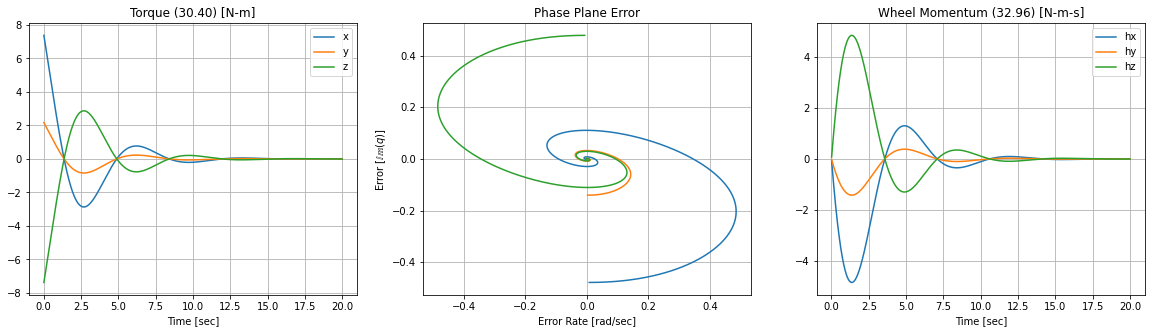

In [106]:
plotStates(ti,yi,qd)
plotControl(ti,ui,err,errdot,step,yi[:,7:10])

## Feedforward

Now, we can include a feedforward term in our control command which should help with performance.

$$
u = \hat u - K \sat{\frac{s}{\phi}}
$$

We can determine the feedforward term from the sliding surface:

$$
s = \omega_e + \lambda q_{e:xyz} \\
\frac {d}{dt} s = \dot s = \dot \omega_e + \lambda \dot q_{e:xyz} \\
\dot q_{e} = \frac {1}{2} q_e \omega_e \\
\omega_e = J^{-1} \left( \hat u - \omega_e \times J \omega \right) \\
\hat u = \omega_e \times J \omega - \lambda J \frac {1}{2} q_e \omega_e
$$

Thus the final control equation is:

$$
u = \omega_e \times J \omega - \lambda J \frac {1}{2} q_e \omega_e - K \sat{\frac{s}{\phi}}
$$

In [88]:
ti = []
yi = []
ui = []
err = []
errdot = []

sat = SatelliteWheels()
Js = 1.05*sat.J # error, we are off on inertia matrix

step = 0.01
t = 0

# [q, w, h_w]
y = np.zeros(10)
y[:4] = Quaternion() # set starting quaternion

for i in range(2000):
    u = np.zeros(3)
    q = Quaternion(*y[:4])
    qe = qd.conjugate * q
    axis = np.array(qe.vector)
    
    we = y[4:7]
    qwe = Quaternion(0, *we)
    L = 5
    K = 5
    s = we + L*axis
    qde = np.array((0.5*qe*qwe).vector)
    u = np.cross(we, Js @ we) - L * Js @ qde - K * saturate(s)
    # u = -u
    # u = sat.torqueLimit(u, limit=100, deadzone=0.05)
    # y = sat.momentumLimit(y)
    
    y = rk45(sat.dynamics, [t, t+step], y, args=(u,))
    
    if y.success == False:
        print("Oops")
        
    y = y.y[:,-1]
    yi.append(y)
    t += step
    ti.append(t)
    ui.append(u)
    err.append(qe)
    errdot.append(y[4:7])
    
yi = np.array(yi)
ti = np.array(ti)
ui = np.array(ui)
err = np.array(err)
errdot = np.array(errdot)

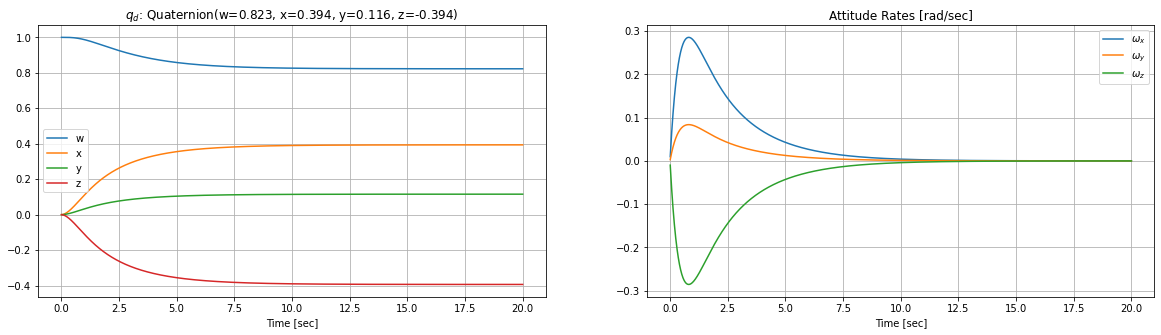

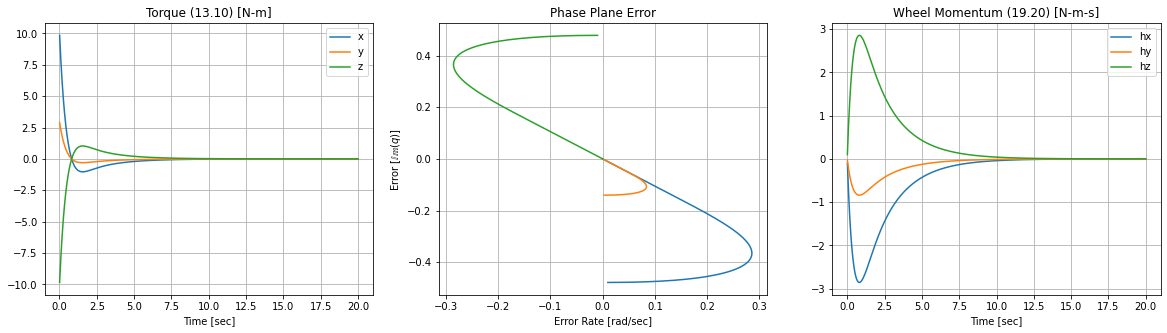

In [89]:
plotStates(ti,yi,qd)
plotControl(ti,ui,err,errdot,step,yi[:,7:10])